transfer learning is taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:

- Can leverage an existing neural network architecture proven to work on problems similar to our own.
- Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

In [1]:
!nvidia-smi

Sat Feb 25 09:36:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download the data (10% of 10 food classes from food 101)

In [2]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-02-25 09:36:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.2MB/s    in 7.9s    

2023-02-25 09:36:25 (20.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os 

for path, folders, filenames in os.walk('./10_food_classes_10_percent'):
  print(f"There are {len(folders)} folders and {len(filenames)} images in the path {path}")

There are 2 folders and 0 images in the path ./10_food_classes_10_percent
There are 10 folders and 0 images in the path ./10_food_classes_10_percent/train
There are 0 folders and 75 images in the path ./10_food_classes_10_percent/train/steak
There are 0 folders and 75 images in the path ./10_food_classes_10_percent/train/pizza
There are 0 folders and 75 images in the path ./10_food_classes_10_percent/train/fried_rice
There are 0 folders and 75 images in the path ./10_food_classes_10_percent/train/chicken_wings
There are 0 folders and 75 images in the path ./10_food_classes_10_percent/train/sushi
There are 0 folders and 75 images in the path ./10_food_classes_10_percent/train/grilled_salmon
There are 0 folders and 75 images in the path ./10_food_classes_10_percent/train/ice_cream
There are 0 folders and 75 images in the path ./10_food_classes_10_percent/train/chicken_curry
There are 0 folders and 75 images in the path ./10_food_classes_10_percent/train/ramen
There are 0 folders and 75 i

In [4]:
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
from matplotlib.transforms import BboxTransform
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = IMAGE_SHAPE,
                                               batch_size = BATCH_SIZE,
                                               class_mode = 'categorical')

test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size = IMAGE_SHAPE,
                                               batch_size = BATCH_SIZE,
                                               class_mode = 'categorical')


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### Setting up callbacks

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

* Experiment tracking with TensorBoard - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [7]:
import tensorflow as tf

In [8]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d %H%M%S')
  tensorbaord_callback = tf.keras.callbacks.TensorBoard(log_dir)
  print(f'Saving tensorbaord logfiles to {log_dir}')
  return tensorbaord_callback

### Creating models using tensorflow hub

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

## Create RESNET model

In [11]:
# a create model function that creates model from a url
def create_model(model_url, num_classes = 10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """

  # Download the pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable = False,
                                           name = 'feature_extractor_layer',
                                           input_shape = IMAGE_SHAPE+(3,))
  
  # Create aour usual keras sequential model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
  ])

  return model

In [12]:
# Create resnet model (tensorflow hub)

resnet_model = create_model(resnet_url, train_data.num_classes)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [15]:
!mkdir tensorboard

In [33]:
resnet_model_history_1 = resnet_model.fit(train_data, epochs = 5,
                                         steps_per_epoch = len(train_data), 
                                         validation_data = test_data, validation_steps = len(test_data), 
                                          callbacks = [create_tensorboard_callback(dir_name = 'tensorboard', experiment_name = 'resnet_model_1')])

Saving tensorbaord logfiles to tensorboard/resnet_model_1/20230225 101855
Epoch 1/5
24/24 [==============================] - 17s 717ms/step - loss: 0.3072 - accuracy: 0.9480 - val_loss: 0.6609 - val_accuracy: 0.7776
Epoch 2/5
24/24 [==============================] - 17s 724ms/step - loss: 0.2534 - accuracy: 0.9640 - val_loss: 0.6415 - val_accuracy: 0.7832
Epoch 3/5
24/24 [==============================] - 16s 696ms/step - loss: 0.2115 - accuracy: 0.9760 - val_loss: 0.6282 - val_accuracy: 0.7904
Epoch 4/5
24/24 [==============================] - 16s 688ms/step - loss: 0.1845 - accuracy: 0.9827 - val_loss: 0.6277 - val_accuracy: 0.7868
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.1563 - accuracy: 0.9907 - val_loss: 0.6197 - val_accuracy: 0.7888


In [34]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

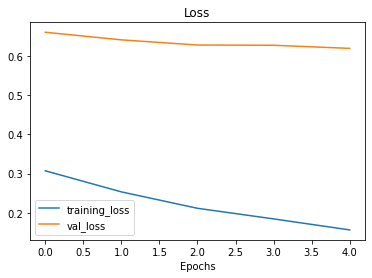

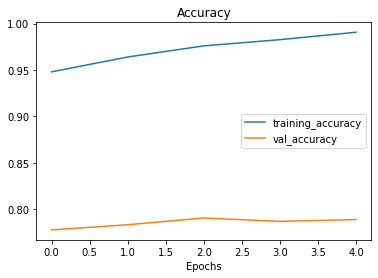

In [35]:
plot_loss_curves(resnet_model_history_1)

## Create EfficientNet

In [36]:
eff_net = create_model(model_url = efficientnet_url, num_classes= train_data.num_classes)

eff_net.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

history_eff_net = eff_net.fit(train_data, epochs = 5,
                              steps_per_epoch = len(train_data),
                              validation_data = test_data, 
                              validation_steps = len(test_data),
                              callbacks = [create_tensorboard_callback(dir_name = 'tensorboard', experiment_name = 'efficient_net')])

Saving tensorbaord logfiles to tensorboard/efficient_net/20230225 102039
Epoch 1/5
24/24 [==============================] - 36s 1s/step - loss: 1.8196 - accuracy: 0.4373 - val_loss: 1.3008 - val_accuracy: 0.7236
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 1.0564 - accuracy: 0.7533 - val_loss: 0.8717 - val_accuracy: 0.8068
Epoch 3/5
24/24 [==============================] - 16s 671ms/step - loss: 0.7514 - accuracy: 0.8400 - val_loss: 0.6999 - val_accuracy: 0.8500
Epoch 4/5
24/24 [==============================] - 15s 653ms/step - loss: 0.6030 - accuracy: 0.8693 - val_loss: 0.6120 - val_accuracy: 0.8608
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.5114 - accuracy: 0.8920 - val_loss: 0.5560 - val_accuracy: 0.8668


In [37]:
eff_net.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


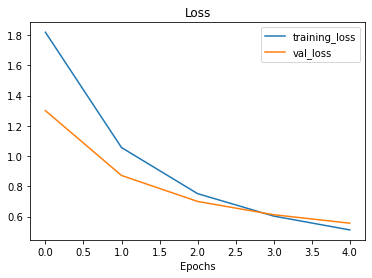

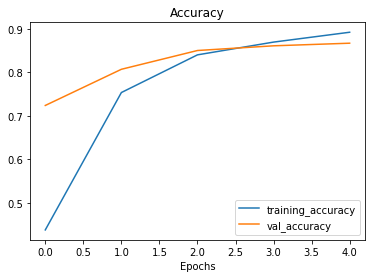

In [38]:
plot_loss_curves(history_eff_net)

## Comparing models using TensorBoard

In [41]:
!tensorboard dev upload --logdir ./tensorboard/ \
  --name "EfficientNetB0 vs. ResNet50V2" --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images"  --one_shot

2023-02-25 10:25:43.088350: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-25 10:25:43.088449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-25 10:25:43.088468: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorboard/

This TensorBoard w

our tensorboard experiments are uploaded publicly <a href=https://tensorboard.dev/experiment/7sRVo06RTki23dn2Xq8oZA/ target=blank>here</a>

In [42]:
# Check out experiments
!tensorboard dev list

2023-02-25 10:32:15.397932: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-25 10:32:15.398030: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-25 10:32:15.398048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
https://tensorboard.dev/experiment/7sRVo06RTki23dn2Xq8oZA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub fea

In [43]:
# Delete an experiment
# !tensorboard dev delete --experiment_id [experiment_id]